In [22]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [23]:
import glob
import torch
from collections import defaultdict
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import FedVAE
from data_funcs import load_data
from utils.logger import Logger
import utils.gan_utils as gan_utils

## Init setting and model

In [24]:
Logger.setup_logging("INFO", logfile="")
Logger()

image_size = 32
channels = 3

dataset_name = "damnist"
data_path = "../data/"
num_workers = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
num_classes = 10

batch_size = 32
lr = 1e-3
epochs = 50

In [25]:
loader_kwargs = {}
if not device == 'cpu':
    loader_kwargs["num_workers"] = num_workers
    loader_kwargs["persistent_workers"] = num_workers > 0

In [26]:
_, test_dataset = load_data(dataset=dataset_name, path=data_path)

## Load test dataset

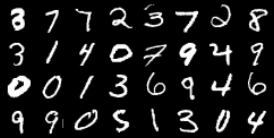

tensor([3, 7, 7, 2, 3, 7, 2, 8], device='mps:0')
tensor([3, 1, 4, 0, 7, 9, 4, 9], device='mps:0')
tensor([0, 0, 1, 3, 6, 9, 4, 6], device='mps:0')
tensor([9, 9, 0, 5, 1, 3, 0, 4], device='mps:0')


In [27]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, **loader_kwargs)
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5+0.5*x))))
    for i in range(0, y.size(0), 8):
        print(y[i:i+8])
    break

## Load model

In [28]:
def init_model():
    return FedVAE(in_channels=3, latent_dim=64, image_size=32)

model = init_model().to(device)
sum(p.numel() for p in model.parameters())

985059

## Train a latent transform from representation (one style)

In [29]:
model = init_model().to(device)
optim = torch.optim.Adam([{'params': model.parameters()}], lr=lr)

In [30]:
losses = defaultdict(list)
for epoch in range(epochs):
    mean_losses = defaultdict(float)
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        x_recon, mu, log_var = model(x)
        kld_weight = 0.005
        kld_weight = (model.latent_dim / (x.shape[1] * x.shape[2] * x.shape[3])) / (len(test_loader))
        loss = model.loss_fn(x, x_recon, mu, log_var, kld_weight=kld_weight)
        # Calculate loss and optimize
        optim.zero_grad(); loss["loss"].backward(); optim.step()
        for k, v in loss.items():
            mean_losses[k] += v.item() / len(test_loader)
    # Record epoch mean loss and acc
    for k, v in mean_losses.items():
        losses[k] += [v]
    print(f"[{epoch+1}/{epochs}] " + \
          '\t'.join([f"{k} = {v:4f}" for k, v in mean_losses.items()]))

[1/50] loss = 0.108822	Reconstruction_Loss = 0.094055	KLD = 55.464260
[2/50] loss = 0.054826	Reconstruction_Loss = 0.038315	KLD = 62.014749
[3/50] loss = 0.046642	Reconstruction_Loss = 0.030951	KLD = 58.933430
[4/50] loss = 0.041842	Reconstruction_Loss = 0.026893	KLD = 56.147627
[5/50] loss = 0.039204	Reconstruction_Loss = 0.024720	KLD = 54.401861
[6/50] loss = 0.037044	Reconstruction_Loss = 0.022820	KLD = 53.426066
[7/50] loss = 0.035663	Reconstruction_Loss = 0.021664	KLD = 52.580696
[8/50] loss = 0.034423	Reconstruction_Loss = 0.020547	KLD = 52.120609
[9/50] loss = 0.033974	Reconstruction_Loss = 0.020140	KLD = 51.962730
[10/50] loss = 0.033023	Reconstruction_Loss = 0.019270	KLD = 51.655725
[11/50] loss = 0.032509	Reconstruction_Loss = 0.018834	KLD = 51.363124
[12/50] loss = 0.031954	Reconstruction_Loss = 0.018345	KLD = 51.114037
[13/50] loss = 0.031417	Reconstruction_Loss = 0.017819	KLD = 51.074698
[14/50] loss = 0.031230	Reconstruction_Loss = 0.017618	KLD = 51.128298
[15/50] loss = 

KeyboardInterrupt: 

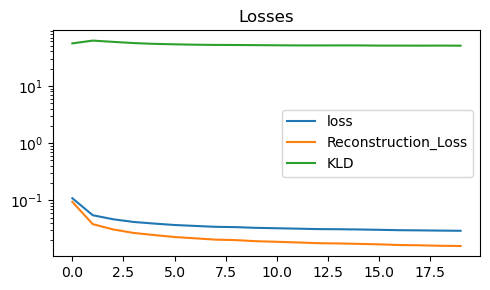

In [31]:
plt.figure()
for k, v in losses.items():
    plt.semilogy(v, label=k)
plt.title("Losses")
plt.legend()
plt.tight_layout()
# plt.savefig(f"results/vae.pdf")

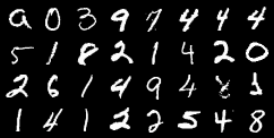

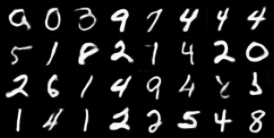

In [32]:
def show_sample(t):
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5*t+0.5))))


x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

show_sample(x)

# Get features from discriminators
with torch.no_grad():
    x_recon, _, _ = model(x)

show_sample(x_recon)

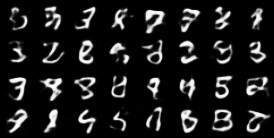

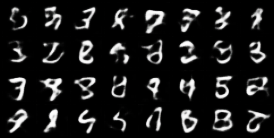

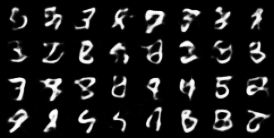

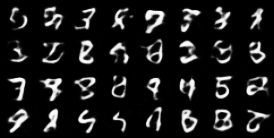

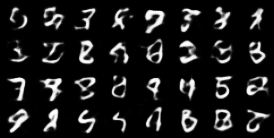

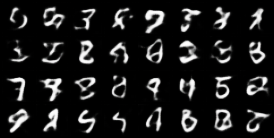

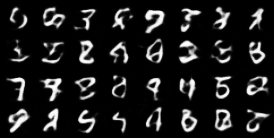

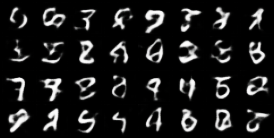

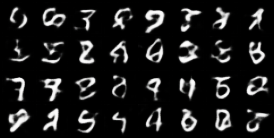

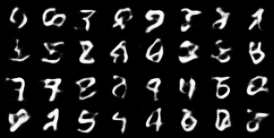

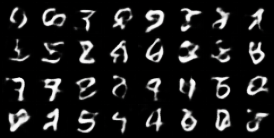

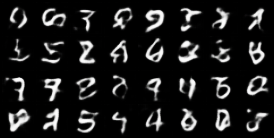

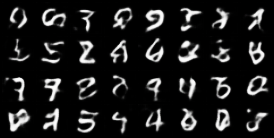

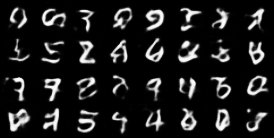

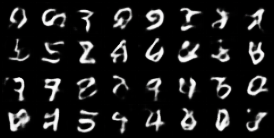

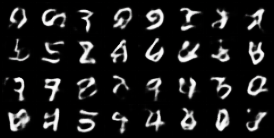

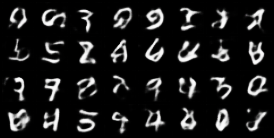

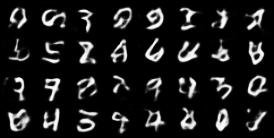

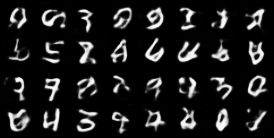

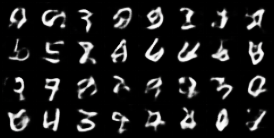

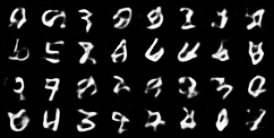

[2024-02-08 02:34:24] (75694) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2024-02-08 02:34:24] (75694) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y vae_interploation.mp4


In [33]:
def slerp(x1, x2, t=None):
    if t is None:
        t = torch.rand(x1.size(0)).to(x1)
    omega = torch.acos((F.normalize(x1)*F.normalize(x2)).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.-t)*omega) / so).unsqueeze(1) * x1 \
        + (torch.sin(t*omega) / so).unsqueeze(1) * x2
    return res


num_samples = 20
frames = []
with torch.no_grad():
    ts = list(torch.linspace(0, 1, num_samples + 1))
    z1 = torch.randn(32, model.latent_dim)
    z2 = torch.randn(32, model.latent_dim)
    for t in ts:
        z = slerp(z1, z2, t=t).to(device)
        fake = model.sample(z=z)
        show_sample(fake)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, padding=2))
gan_utils.make_animation(frames, "vae_interploation.mp4")

In [58]:
num_classes = 10
classifier = nn.Linear(model.latent_dim, num_classes).to(device)
optim = torch.optim.Adam([{'params': classifier.parameters()}], lr=lr * 10)

losses = defaultdict(list)
for epoch in range(epochs):
    mean_losses = defaultdict(float)
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            _, mu, _ = model(x)
        y_pred = classifier(mu)
        loss = F.cross_entropy(y_pred, y)
        acc = (y_pred.cpu().argmax(-1) == y.cpu()).float().mean().to(device)
        loss = {"loss": loss, "accuracy": acc}
        # Calculate loss and optimize
        optim.zero_grad(); loss["loss"].backward(); optim.step()
        for k, v in loss.items():
            mean_losses[k] += v.item() / len(test_loader)
    # Record epoch mean loss and acc
    for k, v in mean_losses.items():
        losses[k] += [v]
    print(f"[{epoch+1}/{epochs}] "
          ', '.join([f"{k} = {v:4f}\t" for k, v in mean_losses.items()])
         )

loss = 0.630369	[1/50] , accuracy = 0.840954	
loss = 0.337507	[2/50] , accuracy = 0.903754	
loss = 0.307101	[3/50] , accuracy = 0.905751	
loss = 0.293691	[4/50] , accuracy = 0.910443	
loss = 0.283858	[5/50] , accuracy = 0.913239	
loss = 0.277206	[6/50] , accuracy = 0.913738	
loss = 0.272362	[7/50] , accuracy = 0.917831	
loss = 0.270064	[8/50] , accuracy = 0.916434	
loss = 0.269629	[9/50] , accuracy = 0.917332	
loss = 0.266899	[10/50] , accuracy = 0.914637	


KeyboardInterrupt: 